# Description of SS - benchmarks deletion

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import numpy as np
import random

# p = os.path.abspath('../')
# if p not in sys.path:
#     sys.path.append(p)
    
# q = os.path.abspath('../../')
# if q not in sys.path:
#     sys.path.append(q)
    
# from vae import *
# from preprocess import SkeletonDataset
import matplotlib.pyplot as plt


import deep_folding as df
from deep_folding.brainvisa.utils.bbox import compute_max_box
from deep_folding.brainvisa.utils.sulcus import complete_sulci_name
from deep_folding.brainvisa.utils.mask import compute_simple_mask
# import matplotlib.cm as cm
# import dico_toolbox as dtx
# import umap
# from scipy.spatial import distance
# from scipy.interpolate import interp1d
# from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

# from sklearn.svm import OneClassSVM
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.ensemble import IsolationForest
# from sklearn.cluster import KMeans, AffinityPropagation
# from sklearn.metrics import silhouette_samples, silhouette_score
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split
# from sklearn import metrics
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
# from sklearn.svm import LinearSVC

### Simple Surface Size Distribution

In [2]:
data_dir = '/neurospin/dico/data/bv_databases/human/hcp/hcp'
mask_dir = '/neurospin/dico/data/deep_folding/current/mask/1mm/'
_DEFAULT_BBOX_DIR = '/neurospin/dico/data/deep_folding/current/bbox/'

In [3]:
subjects_list = '/neurospin/dico/lguillon/distmap/data/test_list.csv'
subjects_list = pd.read_csv(subjects_list)
subjects_list = list(subjects_list['subjects'])

In [4]:
side = 'R'
sub = '100206'
sulci_list = complete_sulci_name(['S.C.'], side)
mask, bbmin, bbmax = compute_simple_mask(sulci_list, side, mask_dir)

only one sulcus: S.C._right


In [5]:
path_to_graph = "t1mri/BL/default_analysis/folds/3.1/deepcnn_auto"
cpt_arg_1 = 't1mri/default_acquisition/default_analysis/folds/3.1/default_session_auto'
cpt_arg_2 = '_default_session_auto.arg'
voxel_size_out = (1, 1, 1, 1)
ss_size = 200

In [38]:
histo_size = {}

for sub in subjects_list:
    graph_file = f"{data_dir}/{sub}/{path_to_graph}/{side}{sub}_deepcnn_auto.arg"

    if os.path.isdir(os.path.join(data_dir, str(sub) + '/')) and os.path.isfile(graph_file):
        # surfaces = dict()

        graph = aims.read(graph_file)

        g_to_icbm_template = aims.GraphManip.getICBM2009cTemplateTransform(graph)
        voxel_size_in = graph['voxel_size'][:3]

        for v in graph.vertices():
            if 'label' in v:
                bck_map = v['aims_ss']

                # Creation of a volume in ICBM space where to write voxels
                # of the simple surface
                hdr = aims.StandardReferentials.icbm2009cTemplateHeader()
                resampling_ratio = np.array(hdr['voxel_size']) / voxel_size_out
                orig_dim = hdr['volume_dimension']
                new_dim = list((resampling_ratio * orig_dim).astype(int))

                vol = aims.Volume(new_dim, dtype='S16')
                vol.copyHeaderFrom(hdr)
                vol.header()['voxel_size'] = voxel_size_out
                arr = np.asarray(vol)
                # Transformation of SS voxels to ICBM space with voxel_size_out
                voxels_icbm = np.asarray(
                    [g_to_icbm_template.transform(np.array(voxel) * voxel_size_in)
                     for voxel in bck_map[0].keys()])
                voxels = np.round(np.array(voxels_icbm) / voxel_size_out[:3]).astype(int)
                # Writing of the voxels in the created volume
                for i,j,k in voxels:
                    arr[i,j,k,0] = 1
                # Suppression of all voxels out of the mask
                arr[np.array(mask)<1]=0
                # Selection of the ss if a mininum of voxels remains
                size = np.count_nonzero(arr>0)
                if np.count_nonzero(arr>0)>ss_size and np.count_nonzero(arr>0)<500:
                    print(v['label'], bck_map[0].size())
                    print(np.count_nonzero(arr == 1))
                    print(np.count_nonzero(arr>0))
                    # surfaces[len(surfaces)] = v
                    if size in histo_size.keys():
                        histo_size[size] += 1
                    else: 
                         histo_size[size] = 1
    print(histo_size)

F.C.L.p._right 1092
201
201
F.C.L.r.retroC.tr._right 472
219
219
{201: 1, 219: 1}
F.I.P.Po.C.inf._right 966
477
477
{201: 1, 219: 1, 477: 1}
S.Po.C.sup._right 444
326
326
F.I.P.Po.C.inf._right 556
424
424
F.I.P.Po.C.inf._right 328
256
256
F.I.P.Po.C.inf._right 436
322
322
{201: 1, 219: 1, 477: 1, 326: 1, 424: 1, 256: 1, 322: 1}
S.C.sylvian._right 303
214
214


KeyboardInterrupt: 

In [40]:
histo_size = {}

for sub in tqdm(subjects_list):
    graph_file = f"{data_dir}/{sub}/{path_to_graph}/{side}{sub}_deepcnn_auto.arg"

    if os.path.isdir(os.path.join(data_dir, str(sub) + '/')) and os.path.isfile(graph_file):
        # surfaces = dict()

        graph = aims.read(graph_file)

        g_to_icbm_template = aims.GraphManip.getICBM2009cTemplateTransform(graph)
        voxel_size_in = graph['voxel_size'][:3]

        for v in graph.vertices():
            if 'label' in v:
                bck_map = v['aims_ss']

                # Creation of a volume in ICBM space where to write voxels
                # of the simple surface
                hdr = aims.StandardReferentials.icbm2009cTemplateHeader()
                resampling_ratio = np.array(hdr['voxel_size']) / voxel_size_out
                orig_dim = hdr['volume_dimension']
                new_dim = list((resampling_ratio * orig_dim).astype(int))

                vol = aims.Volume(new_dim, dtype='S16')
                vol.copyHeaderFrom(hdr)
                vol.header()['voxel_size'] = voxel_size_out
                arr = np.asarray(vol)
                # Transformation of SS voxels to ICBM space with voxel_size_out
                voxels_icbm = np.asarray(
                    [g_to_icbm_template.transform(np.array(voxel) * voxel_size_in)
                     for voxel in bck_map[0].keys()])
                voxels = np.round(np.array(voxels_icbm) / voxel_size_out[:3]).astype(int)
                # Writing of the voxels in the created volume
                for i,j,k in voxels:
                    arr[i,j,k,0] = 1
                # Suppression of all voxels out of the mask
                arr[np.array(mask)<1]=0
                # Selection of the ss if a mininum of voxels remains
                size = np.count_nonzero(arr>0)
#                 if np.count_nonzero(arr>0)>ss_size and np.count_nonzero(arr>0)<500:
#                     print(v['label'], bck_map[0].size())
#                     print(np.count_nonzero(arr == 1))
#                     print(np.count_nonzero(arr>0))
#                     # surfaces[len(surfaces)] = v
                if size in histo_size.keys():
                    histo_size[size] += 1
                else: 
                     histo_size[size] = 1

100%|██████████| 200/200 [1:50:51<00:00, 33.26s/it]


In [6]:
skel_size = {}

for sub in tqdm(subjects_list):
    total_vox_sub = 0
    
    graph_file = f"{data_dir}/{sub}/{path_to_graph}/{side}{sub}_deepcnn_auto.arg"

    if os.path.isdir(os.path.join(data_dir, str(sub) + '/')) and os.path.isfile(graph_file):
        # surfaces = dict()

        graph = aims.read(graph_file)

        g_to_icbm_template = aims.GraphManip.getICBM2009cTemplateTransform(graph)
        voxel_size_in = graph['voxel_size'][:3]

        for v in graph.vertices():
            if 'label' in v:
                bck_map = v['aims_ss']

                # Creation of a volume in ICBM space where to write voxels
                # of the simple surface
                hdr = aims.StandardReferentials.icbm2009cTemplateHeader()
                resampling_ratio = np.array(hdr['voxel_size']) / voxel_size_out
                orig_dim = hdr['volume_dimension']
                new_dim = list((resampling_ratio * orig_dim).astype(int))

                vol = aims.Volume(new_dim, dtype='S16')
                vol.copyHeaderFrom(hdr)
                vol.header()['voxel_size'] = voxel_size_out
                arr = np.asarray(vol)
                # Transformation of SS voxels to ICBM space with voxel_size_out
                voxels_icbm = np.asarray(
                    [g_to_icbm_template.transform(np.array(voxel) * voxel_size_in)
                     for voxel in bck_map[0].keys()])
                voxels = np.round(np.array(voxels_icbm) / voxel_size_out[:3]).astype(int)
                # Writing of the voxels in the created volume
                for i,j,k in voxels:
                    arr[i,j,k,0] = 1
                # Suppression of all voxels out of the mask
                arr[np.array(mask)<1]=0

                size = np.count_nonzero(arr>0)
                total_vox_sub += size
                
        if total_vox_sub in skel_size.keys():
            skel_size[total_vox_sub] += 1
        else: 
             skel_size[total_vox_sub] = 1

100%|██████████| 200/200 [1:48:18<00:00, 32.49s/it]


In [2]:
import csv
with open('dict_skel_size_dstrb.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in skel_size.items():
        writer.writerow([key, value])

NameError: name 'skel_size' is not defined

In [33]:
skel_size_reader = pd.read_csv('/neurospin/dico/lguillon/distmap/article/material_figures/dict_skel_size_dstrb.csv',
                              header=None, names=['size_ss', 'n'])

In [61]:
skel_size_list = []
for k in range(len(skel_size_reader)):
    row = skel_size_reader.loc[k]
    skel_size_list += row.n*[row.size_ss]

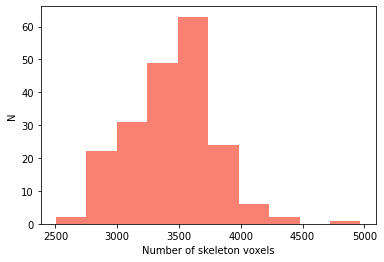

In [62]:
plt.hist(skel_size_list, color='salmon')
plt.xlabel('Number of skeleton voxels')
plt.ylabel('N')
plt.show()

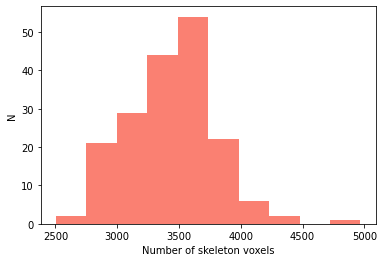

In [12]:
import copy
skel_size_xo_0 = copy.deepcopy(skel_size)

#del skel_size_xo_0[0]
plt.hist(skel_size_xo_0, color='salmon')
# plt.xticks([0, 200, 500, 700, 1000, 1500, 2000, 2500])
plt.xlabel('Number of skeleton voxels')
plt.ylabel('N')
plt.show()